$\dot{\vec p} = \frac{1}{2\beta}[\vec{k} - (\vec k \cdot \vec p)\vec p] + \frac 1 2 \vec \omega \times \vec p$

$\beta = \mu \alpha /2\rho g h$

$\vec \omega = \nabla \times \vec v_{flow}$

$v_{flow} = Ar + \frac B r \implies \vec \omega = (0, 0, 2A)$ 

$A = \cfrac{-\Omega}{R_2^2/R_1^2-1} \space B = \cfrac{\Omega R_2^2}{R_2^2/R_1^2-1}$

$\dot{\vec R} =  v_0 \vec p + \vec v_{flow}$

Cut-off Lennard-Jones potential

$$ V_W = 
\begin{cases}
    4\varepsilon \left[ (\frac{\sigma_W}{r}) ^{12} - (\frac{\sigma_W}{r}) ^{6}\right] +\varepsilon, \ \text{for} \ r<d^*\\
      0
    \end{cases} $$
$$d^* = 2^{1/6}  \sigma_W =R  \quad \sigma_W = R/2^{1/6}$$
$$ F_W = -\cfrac{\partial V_W}{\partial r}$$


$\dot{\vec p^i} = \frac{1}{2B}[\vec{k} - (\vec k \cdot \vec p^i)\vec p^i] + \frac 1 2 \vec \omega \times \vec p^i, B = \mu \alpha /2\rho g h,  \vec \omega = \nabla \times \vec v_{flow}, \vec v_{flow} = (-Ay, Ax, 0)$ 

$\dot{\vec R^i} =  v_0 \vec p^i  + \vec v_{flow} + \mu(\sum\limits_{i\neq j } \vec F_S^{ij} + \sum\limits_{j'} \vec F_W^{ij'})$

$\gamma = 6\pi\eta R \quad \mu = 1/\gamma$

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def data_for_cylinder_along_z(radius, height_z, null_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2 * np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z + null_z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    return x_grid, y_grid, z_grid

In [3]:
# constants

R = 1 # swimmer radius
v0 = 1 # swimmer speed
eta = 1 # viscosity
R1 = 5 * R # inner radius
R2 = 50 * R # outer radius
Omega = 0.3 # inner rotation speed [0, 0.05]

beta = 200

A = - Omega / (R2 ** 2 / R1 ** 2 - 1)
B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)

Omega_crit = ((R2 / R1) ** 2 - 1) / 2 / beta

if Omega > Omega_crit:
    T_tumb = 4 * np.pi * beta / np.sqrt(4 * A **2 * beta ** 2 - 1)
    print(f'Tumbling period: {T_tumb}')
else:
    print('No tumbling')

mu = 1 / (6 * np.pi * eta * R)

omega = np.array([0, 0, 2 * A])
k = np.array([1, 0, 0]) # up vector


Tumbling period: 3668.963147012449


In [4]:
def get_v_flow(pos):
    R_norm = np.linalg.norm(pos)
    v = A * R_norm + B / R_norm
    return np.array([- v * pos[1] / R_norm, v * pos[0] / R_norm, 0])

In [5]:
def force(r, epsilon, sigma):
    return 24 * epsilon * (2 * sigma ** 12 / r ** 13 - sigma ** 6 / r ** 7)

In [6]:
def get_wall_force(pos):
    R_norm = np.linalg.norm(pos)
    sigma = 2 ** (- 1 / 6) * R
    epsilon = 0.01
    if (R_norm < R1 + R):
        f = force(R_norm - R1, epsilon, sigma)
        F = np.array([f * pos[0] / R_norm, f * pos[1] / R_norm, 0], dtype = float)
    elif (R_norm > R2 - R):
        f = force(R2 - R_norm, epsilon, sigma)
        F = np.array([- f * pos[0] / R_norm, - f * pos[1] / R_norm, 0], dtype = float)
    else:
        F = np.array([0, 0, 0])
    return F

In [7]:
def dot(pR, t, beta, omega, k, v0):
    p = pR[:3]
    R = pR[3:]
    p = p / np.linalg.norm(p)
    p_dot = (k - k @ p * p) / (2 * beta) + 1 / 2 * np.cross(omega, p)
    R_dot = v0 * p + get_v_flow(R[:2]) + mu * get_wall_force(R[:2])
    #R_dot = v0 * p + get_v_flow(R[:2])
    return np.hstack((p_dot, R_dot))

In [8]:
R0 = np.array([15 * R, 0, 0])
p0 = np.array([0, 1, 0])
t = np.linspace(0, 5000, 100)

sol = odeint(dot, np.hstack((p0, R0)), t, args=(beta, omega, k, v0))


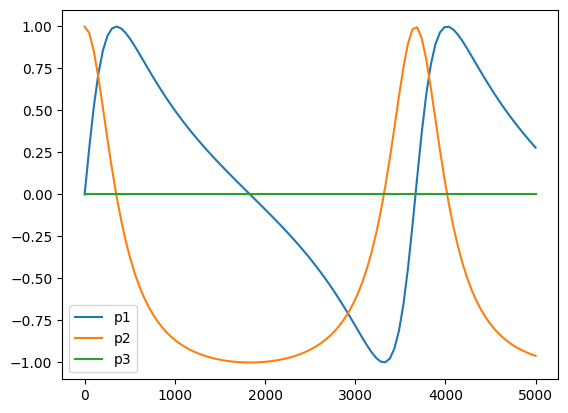

In [9]:
plt.figure()
plt.plot(t, sol[:,0], label='p1')
plt.plot(t, sol[:,1], label='p2')
plt.plot(t, sol[:,2], label='p3')
plt.legend();

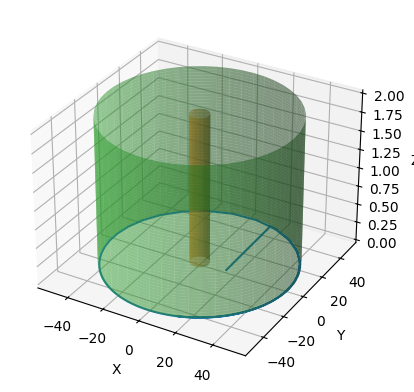

In [10]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(sol[:, 3], sol[:, 4], sol[:, 5])

X1,Y1,Z1 = data_for_cylinder_along_z(R1, 2, 0)
ax.plot_surface(X1, Y1, Z1, alpha=0.5)

X2,Y2,Z2 = data_for_cylinder_along_z(R2, 2, 0)
ax.plot_surface(X2, Y2, Z2, alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()